In [1]:
from importlib import reload
import json
import pretty_midi
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers

In [ ]:
# check gpu
print(tf..device_lib.list_local_devices())

In [2]:
import modules.midiMethods as midiMethods
reload(midiMethods)
from modules.midiMethods import *

import modules.dataMethods as dataMethods
reload(dataMethods)
from modules.dataMethods import *

import modules.models as models
reload(models)

import modules.mlClasses as mlClasses
reload(mlClasses)


<module 'modules.mlClasses' from '/home/ubuntu/storage/380-music-representation/modules/mlClasses.py'>

In [123]:
# if needed, read in filenames... specify if validation or test
maestro = pd.read_csv('training_data/maestro-v2.0.0withPeriod.csv', index_col=0)
filenames = list(maestro[maestro['split'] == 'train']['midi_filename'])

In [4]:
# load data
with open('training_data/oore_v1/oore_train.json', 'r') as f:
    X_train = json.load(f)
    
with open('training_data/oore_v1/oore_val.json', 'r') as f:
    X_val = json.load(f)

In [5]:
# build simple model
# excellent example of recurrent model here https://www.tensorflow.org/tutorials/text/text_generation
hidden_state = 512
lstm_layers = 3
seq_length = len(X_train[0]) - 1
model2 = models.create_ooremodel(hidden_state_size=hidden_state, lstm_layers=lstm_layers,
                              seq_length=seq_length)
training_generator = mlClasses.OoreDataGenerator(X_train, augment=False)
val_gen = mlClasses.OoreDataGenerator(X_val, augment=False)

Model: "3layerLSTM"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 255, 1)]          0         
_________________________________________________________________
lambda (Lambda)              (None, 255, 333)          0         
_________________________________________________________________
lstm (LSTM)                  (None, 255, 512)          1732608   
_________________________________________________________________
lstm_1 (LSTM)                (None, 255, 512)          2099200   
_________________________________________________________________
lstm_2 (LSTM)                (None, 255, 512)          2099200   
_________________________________________________________________
dense (Dense)                (None, 255, 333)          170829    
Total params: 6,101,837
Trainable params: 6,101,837
Non-trainable params: 0
______________________________________________

In [7]:
opt = tf.keras.optimizers.Adam(learning_rate=0.0005)
model2.compile(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
checkpoint = tf.keras.callbacks.ModelCheckpoint("models/oore1/{epoch:02d}-{val_loss:.2f}.hdf5", monitor='val_loss', verbose=2, save_best_only=True, save_weights_only=True)
stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=5)
epochs=40
history2 = model2.fit_generator(training_generator, validation_data=val_gen, epochs=epochs, callbacks=[checkpoint, stop])
# model2.save_weights(f'models/oore2/model{epochs}e{hidden_state}ss{lstm_layers}l.h5')
with open(f'models/oore2/history{epochs}e.json', 'w') as f:
    json.dump(str(history2.history), f)


Epoch 1/40
1170/1171 [============================>.] - ETA: 0s - loss: 3.8895 - accuracy: 0.1074
Epoch 00001: val_loss improved from inf to 3.37127, saving model to models/oore1/01-3.37.hdf5
1171/1171 [==============================] - 649s 554ms/step - loss: 3.8891 - accuracy: 0.1074 - val_loss: 3.3713 - val_accuracy: 0.1400
Epoch 2/40
1170/1171 [============================>.] - ETA: 0s - loss: 3.2125 - accuracy: 0.1605
Epoch 00002: val_loss improved from 3.37127 to 3.07304, saving model to models/oore1/02-3.07.hdf5
1171/1171 [==============================] - 651s 556ms/step - loss: 3.2124 - accuracy: 0.1605 - val_loss: 3.0730 - val_accuracy: 0.1837
Epoch 3/40
1170/1171 [============================>.] - ETA: 0s - loss: 2.9523 - accuracy: 0.2082
Epoch 00003: val_loss improved from 3.07304 to 2.86343, saving model to models/oore1/03-2.86.hdf5
1171/1171 [==============================] - 653s 558ms/step - loss: 2.9523 - accuracy: 0.2082 - val_loss: 2.8634 - val_accuracy: 0.2254
Epoch

NameError: name 'history' is not defined

In [69]:
# This works just like this:
import modules.models as models
reload(models)

<module 'modules.models' from '/home/ubuntu/storage/380-music-representation/modules/models.py'>

In [8]:
# tf.train.latest_checkpoint('weights\first_attempt')
hidden_state = 512
lstm_layers = 3
prediction_model = models.create_ooremodel(batch_size=1, stateful=True, hidden_state_size=hidden_state, lstm_layers=lstm_layers)

Model: "3layerLSTM"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(1, 600, 1)]             0         
_________________________________________________________________
lambda (Lambda)              (1, 600, 242)             0         
_________________________________________________________________
lstm (LSTM)                  (1, 600, 512)             1546240   
_________________________________________________________________
lstm_1 (LSTM)                (1, 600, 512)             2099200   
_________________________________________________________________
lstm_2 (LSTM)                (1, 600, 512)             2099200   
_________________________________________________________________
dense (Dense)                (1, 600, 242)             124146    
Total params: 5,868,786
Trainable params: 5,868,786
Non-trainable params: 0
______________________________________________

In [12]:
# prediction_model.load_weights('weights/note_bin/model2_60epochs512state3layer.h5')
prediction_model.load_weights('models/oore7/12-1.76.hdf5')
for temperature in [0.055,0.056,0.057]:
    input_events = pm2oore2(pretty_midi.PrettyMIDI('midi/starts/spa2.mid'))
    new_seq_length = 600
    new_seq = models.generate_ooremusic(prediction_model, new_seq_length, temperature=temperature, input_events=input_events)
    ns = [int(event) for event in new_seq]
    pm = oore2pm2(ns)
    pm.write(f'midi/oore/2_notes-{new_seq_length}long-{temperature}.mid')

In [15]:
# prediction_model.load_weights('weights/note_bin/model2_60epochs512state3layer.h5')
prediction_model.load_weights('models/oore8/32-1.92.hdf5')
for temperature in [0.051, 0.052]:
    input_events = pm2oore2(pretty_midi.PrettyMIDI('midi/starts/spa1.mid'))
    new_seq_length = 600
    new_seq = models.generate_ooremusic(prediction_model, new_seq_length, temperature=temperature, input_events=input_events)
    ns = [int(event) for event in new_seq]
    pm = oore2pm2(ns)
    pm.write(f'midi/oore_v2/overfittedOore8/2_notes-{new_seq_length}long-{temperature}.mid')

In [9]:
note_bin2pm(input_notes).write('midi/hellad.mid')

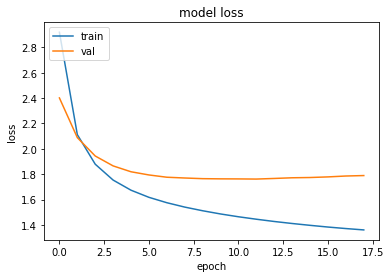

In [3]:
import ast
with open(f'models/oore5/history40e.json', 'r') as f:
    hist = ast.literal_eval(json.load(f))
metric = 'loss'
models.plt_metric(hist)

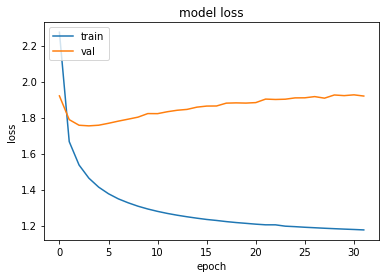

In [7]:
with open(f'models/oore8/history32e.json', 'r') as f:
    hist2 = ast.literal_eval(json.load(f))
metric = 'loss'
models.plt_metric(hist2)

In [8]:
hist['loss']

[2.9193361195321317,
 2.112031763195236,
 1.8787353257867019,
 1.753449133442684,
 1.6734976863679778,
 1.6174096292113775,
 1.5749120189512034,
 1.5403910426585847,
 1.5115569493012133,
 1.4862168164609806,
 1.4641268791203566,
 1.4447127662230808,
 1.4268857458245165,
 1.4110354763775572,
 1.396523674178033,
 1.3830689081523204,
 1.3711494278394074,
 1.360416857915233]

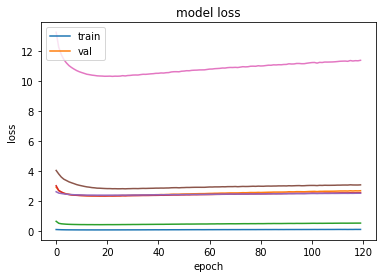

In [8]:
pm = 
metric = 'loss'
# print(hist)
plt.plot(hist['val_dense_1_' + metric])
plt.plot(hist['val_dense_2_' + metric])
plt.plot(hist['val_dense_3_' + metric])
plt.plot(hist['val_dense_4_' + metric])
plt.plot(hist['val_dense_5_' + metric])
plt.plot(hist['val_dense_' + metric])
plt.plot(hist['val_' + metric])
plt.title('model ' + metric)
plt.ylabel(metric)
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [6]:

pm = pretty_midi.PrettyMIDI(f'midi/LisztNoPedal.mid')
oo = pm2oore2(pm)
print(oo[:10])
pm2 = oore2pm2(oo)
pm2.write('midi/LisztOore2Test20.mid')
              

[218, 237, 39, 27, 180, 238, 15, 237, 3, 203]


In [8]:
for i in range(0,7,2):
    print(i)

0
2
4
6
